In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

C:\Users\shakt\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\shakt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\shakt\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


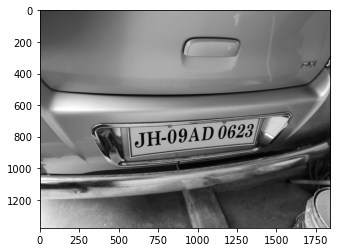

In [2]:
#Importing image and transforming it to gray scale
img = cv2.imread('car_plate.jpg')
img_bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_bw,cmap="gray")

In [3]:
car_plate_cls = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_russian_plate_number.xml')

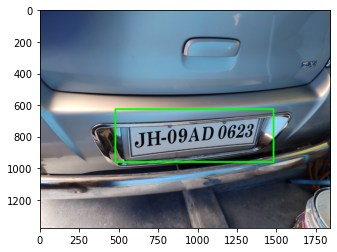

In [4]:

# Setup function to detect car plate
def carplate_detect(img):
    carplate_overlay = img.copy() 
    carplate_rects = car_plate_cls.detectMultiScale(carplate_overlay,scaleFactor=1.1, minNeighbors=5)
    for x,y,w,h in carplate_rects: 
        cv2.rectangle(carplate_overlay, (x,y), (x+w,y+h), (0,255,0), 10) 
        
    return carplate_overlay


detected_carplate_img = carplate_detect(img)
plt.imshow(detected_carplate_img)

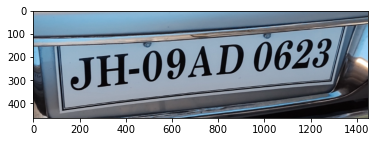

In [5]:
# Create function to retrieve only the car plate region itself
def carplate_extract(image):
    
    carplate_rects = car_plate_cls.detectMultiScale(image,scaleFactor=1.1, minNeighbors=5)
    for x,y,w,h in carplate_rects: 
            carplate_img = image[y+15:y+h-10 ,x+15:x+w-20] # Adjusted to extract specific region of interest i.e. car license plate
        
    return carplate_img

# Enlarge image for further processing later on
def enlarge_img(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized_image

# Display extracted car license plate image
carplate_extract_img = carplate_extract(img)
carplate_extract_img = enlarge_img(carplate_extract_img, 150)
plt.imshow(carplate_extract_img)

# Downloading detection and recognition model

In [6]:
import easyocr

In [7]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [8]:
detect_number = reader.readtext(carplate_extract_img)
detect_number

C:\Users\shakt\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[([[936, 92], [1314, 92], [1314, 287], [936, 287]],
  '0623',
  0.9999923706054688),
 ([[150.37121096182938, 188.31590248242742],
   [938.0167132915511, 112.64931586332312],
   [939.6287890381707, 286.6840975175726],
   [150.98328670844884, 362.3506841366769]],
  'JH-09AD',
  0.7501481859346093)]

In [9]:
final = detect_number[1][1]+detect_number[0][1]
n=""
final_plate =final.split('-')

final_plate = n.join(final_plate)
final_plate

'JH09AD0623'

In [10]:
import requests
import json
import xmltodict
import parser

def get_vehicle_info(final_plate):
    r=requests.get("http://www.regcheck.org.uk/api/reg.asmx/CheckIndia?RegistrationNumber={0}&username=Shweta".format(str(final_plate)))
    data=xmltodict.parse(r.content)
    #data=parser.parse(r.content)
    #data=parser.Parse(r.content, True)
    jdata=json.dumps(data)
    df=json.loads(jdata)
    df1=json.loads(df['Vehicle']['vehicleJson'])
    return df1

In [11]:
if len(final_plate)>10:
    final_plate=final_plate[-10:]
    print(final_plate)

In [12]:
x= get_vehicle_info(final_plate)
x

{'Description': 'MARUTI SUZUKI CELERIO ZXI',
 'RegistrationYear': '2016',
 'CarMake': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'CarModel': {'CurrentTextValue': 'CELERIO ZXI'},
 'Variant': 'ZXi (O) Petrol 998.0',
 'EngineSize': {'CurrentTextValue': '998.0'},
 'MakeDescription': {'CurrentTextValue': 'MARUTI SUZUKI'},
 'ModelDescription': {'CurrentTextValue': 'CELERIO ZXI'},
 'NumberOfSeats': {'CurrentTextValue': '5'},
 'VechileIdentificationNumber': 'MA3ETDE1S00324619',
 'EngineNumber': 'K10BN7749635',
 'FuelType': {'CurrentTextValue': 'PETROL'},
 'RegistrationDate': '14/09/2016',
 'Owner': 'MRS ANJANI DEVI',
 'Fitness': '',
 'Insurance': '2021-08-09',
 'PUCC': '2021-07-08',
 'VehicleType': 'MOTOR CAR(LMV)',
 'Location': 'DTO,BOKARO',
 'ImageUrl': 'http://www.carregistrationapi.in/image.aspx/@TUFSVVRJIFNVWlVLSSBDRUxFUklPIFpYSQ=='}